Battery State of Charge (SoC) Estimation Using Temperature-Compensated Ah Integration with OCV Recalibration

This script simulates the estimation of a battery's State of Charge (SoC) under varying temperature conditions 
using a temperature-compensated Ampere-hour (Ah) integration method combined with periodic Open Circuit Voltage 
(OCV) recalibration. The implementation accounts for the following key factors:

1. **Temperature Compensation**:
   - Adjusts the battery's effective capacity based on operating temperature.
   - Models reduced capacity at lower temperatures (e.g., 0.5% reduction per °C below 25°C).
   - Ensures accurate SoC estimation in environments with fluctuating temperatures.

2. **Ampere-Hour (Ah) Integration**:
   - Tracks the charge flowing into or out of the battery over time.
   - Updates the SoC estimate based on the effective capacity adjusted for temperature.

3. **OCV-Based Recalibration**:
   - Periodically measures the Open Circuit Voltage (OCV) during rest periods to provide an absolute reference 
     for SoC estimation.
   - Blends Coulomb-counted SoC with OCV-based SoC using a weighted average to reduce drift and improve accuracy.

4. **Realistic Simulation**:
   - Includes a dynamic temperature profile to simulate real-world environmental conditions (e.g., Thailand's 
     high-temperature climate).
   - Incorporates noisy and biased current measurements to reflect practical measurement errors.
   - Provides a comparison between temperature-compensated SoC estimation and uncompensated Coulomb counting.

5. **Performance Metrics**:
   - Calculates the Mean Absolute Percentage Error (MAPE) to quantitatively evaluate the accuracy of the 
     compensated and uncompensated SoC estimates.

Use Cases:
- Battery management systems (BMS) for electric vehicles, renewable energy storage, and portable electronics.
- Research and development of advanced SoC estimation algorithms.

Key Functions:
- `temperature_corrected_capacity`: Adjusts nominal capacity based on temperature.
- `ocv_to_soc`: Converts OCV to SoC using a simplified model.
- `recalibrate_soc`: Combines Coulomb-counted SoC with OCV-based SoC for recalibration.
- `ah_integration_temp`: Implements temperature-compensated Ah integration with optional OCV recalibration.
- `calculate_mape`: Computes the Mean Absolute Percentage Error (MAPE) for performance evaluation.

Dependencies:
- Python libraries: `numpy`, `matplotlib`.



MAPE (Estimated SoC): 1.52%
MAPE (Uncompensated SoC): 5.51%


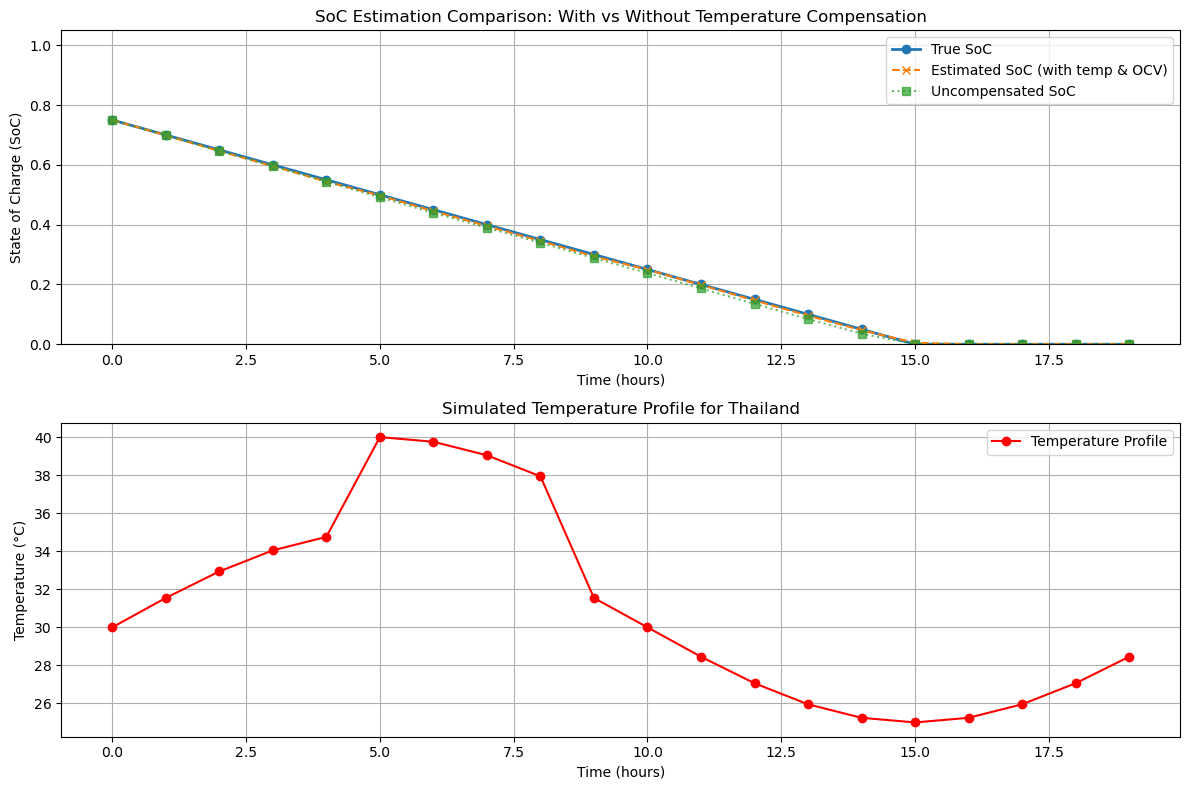

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def temperature_corrected_capacity(nominal_capacity, temperature_c):
    """
    Adjust capacity based on temperature.
    Capacity decreases ~0.5% per °C below 25°C.
    """
    if temperature_c < 25:
        reduction_factor = 1 - 0.005 * (25 - temperature_c)
    else:
        reduction_factor = 1  # No gain above 25°C
    return nominal_capacity * reduction_factor


def ocv_to_soc(ocv):
    """
    Dummy function to map OCV to SoC.
    Replace this with real battery OCV-SoC curve fitting.
    """
    ocv_min = 3.0
    ocv_max = 4.2
    return max(0, min(1, (ocv - ocv_min) / (ocv_max - ocv_min)))


def recalibrate_soc(soc_coulomb, ocv, alpha=0.9):
    """
    Blend Coulomb-counted SoC with OCV-based SoC estimate.
    alpha: weight given to Coulomb result (e.g., 0.9 means 90% trust in integration)
    """
    soc_ocv = ocv_to_soc(ocv)
    return alpha * soc_coulomb + (1 - alpha) * soc_ocv


def ah_integration_temp(soc_initial, current, time_step, nominal_capacity, temperature_c, is_rest_period=False, ocv_measured=None):
    """
    Estimate SoC using Ah integration with temperature correction and optional OCV recalibration.
    """
    capacity_effective = temperature_corrected_capacity(nominal_capacity, temperature_c)
    charge_change = current * time_step  # Ah
    soc_change = charge_change / capacity_effective
    soc_new = soc_initial + soc_change
    soc_new = max(0, min(1, soc_new))  # Clamp SoC

    if is_rest_period and ocv_measured is not None:
        # Apply recalibration
        soc_new = recalibrate_soc(soc_new, ocv_measured, alpha=0.9)

    return soc_new


def ah_integration_uncompensated(soc_initial, current, time_step, nominal_capacity):
    """
    Traditional Coulomb counting without temp compensation or recalibration.
    """
    charge_change = current * time_step
    soc_change = charge_change / nominal_capacity
    soc_new = soc_initial + soc_change
    return max(0, min(1, soc_new))


# Simulation parameters
steps = 20
soc_true = 0.8
soc_est = 0.8
soc_uncomp = 0.8

true_soc_list = []
est_soc_list = []
uncomp_soc_list = []
time_list = []
temperature_profile = []

current = -5          # Discharge current in A
time_step = 1         # Time step in hours
capacity = 100        # Nominal capacity at 25°C
current_bias = 1.02   # 2% bias in current measurement to simulate drift
current_noise_std = 0.1  # Standard deviation of current measurement noise

# Define a realistic high-temperature profile for Thailand
def temperature_profile_function(t):
    """
    Simulate a realistic high-temperature profile for Thailand.
    Example: Baseline at 30°C, small fluctuations (±2°C), and occasional peaks to 35°C.
    """
    baseline = 30  # Typical ambient temperature in Thailand
    fluctuation = 5 * np.sin(2 * np.pi * t / steps)  # Small sinusoidal fluctuations
    peak = 5 if t in [5, 6, 7, 8] else 0  # Occasional peak to 35°C during midday
    return baseline + fluctuation + peak


for t in range(steps):
    # Get the temperature at the current time step
    temperature = temperature_profile_function(t)
    temperature_profile.append(temperature)

    # Effective capacity at the current temperature
    effective_capacity = temperature_corrected_capacity(capacity, temperature)

    # Rest period logic
    is_rest = (t % 5 == 0 and t != 0)  # Rest every 5 steps
    ocv_measured = 3.0 + 1.2 * soc_true if is_rest else None

    # Simulate noisy and biased current measurement
    measured_current = current * current_bias + np.random.normal(0, current_noise_std)

    # Improved estimation with temperature correction and OCV recalibration
    soc_est = ah_integration_temp(soc_est, measured_current, time_step, capacity, temperature, is_rest, ocv_measured)

    # Uncompensated Coulomb counting
    soc_uncomp = ah_integration_uncompensated(soc_uncomp, measured_current, time_step, capacity)

    # Simulated true SoC (affected by temperature)
    soc_true += (current * time_step) / effective_capacity
    soc_true = max(0, min(1, soc_true))

    # Record data
    time_list.append(t)
    true_soc_list.append(soc_true)
    est_soc_list.append(soc_est)
    uncomp_soc_list.append(soc_uncomp)

# Calculate MAPE
def calculate_mape(true_socs, estimated_socs):
    """
    Calculate Mean Absolute Percentage Error (MAPE).
    """
    errors = [
        abs((true_soc - est_soc) / true_soc) * 100
        for true_soc, est_soc in zip(true_socs, estimated_socs)
        if true_soc > 0  # Avoid division by zero
    ]
    return sum(errors) / len(errors) if errors else 0

mape_est = calculate_mape(true_soc_list, est_soc_list)
mape_uncomp = calculate_mape(true_soc_list, uncomp_soc_list)

print(f"MAPE (Estimated SoC): {mape_est:.2f}%")
print(f"MAPE (Uncompensated SoC): {mape_uncomp:.2f}%")

# Plotting
plt.figure(figsize=(12, 8))

# Plot SoC comparison
plt.subplot(2, 1, 1)
plt.plot(time_list, true_soc_list, label="True SoC", marker='o', linewidth=2)
plt.plot(time_list, est_soc_list, label="Estimated SoC (with temp & OCV)", marker='x', linestyle='--')
plt.plot(time_list, uncomp_soc_list, label="Uncompensated SoC", marker='s', linestyle=':', alpha=0.7)
plt.xlabel("Time (hours)")
plt.ylabel("State of Charge (SoC)")
plt.title("SoC Estimation Comparison: With vs Without Temperature Compensation")
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)

# Plot temperature profile
plt.subplot(2, 1, 2)
plt.plot(time_list, temperature_profile, label="Temperature Profile", marker='o', color='red')
plt.xlabel("Time (hours)")
plt.ylabel("Temperature (°C)")
plt.title("Simulated Temperature Profile for Thailand")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()